# Clustering SLIDER Machine

We want to determine the abnormal and normal sound waves based on the features of a machine.
For the pump machine cluster the abnormal and normal sounds based on features such as 
- amp_mean
- spec_roll_mean
- melspec_std

In [1]:
# Import all the necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import rand_score

from sklearn.cluster import KMeans


I will be using the csv file of pump features extracted in the previous project. 
https://github.com/UjjwalKandel2000/Machine-conditions-monitoring
Read the csv file and check the correlatiion with respect to `class` column. Since we have labelled data clustering the data based on the correlation with respect to class can be helpful.

In [2]:
df = pd.read_csv("dataset/slider_features.csv")
correlation = df.corr()
correlation['class'].sort_values(ascending = False)

class             1.000000
amp_mean          0.519006
spec_roll_mean    0.472774
melspec_std       0.465831
spec_cent_mean    0.459535
y_std             0.451597
rms_mean          0.431885
melspec_mean      0.423381
y_max             0.379127
zcr_mean          0.329398
flat_mean         0.278730
flat_max          0.246673
zcr_min           0.196231
zcr_max           0.182205
spec_cent_min     0.152008
spec_roll_min     0.117988
y_mean           -0.007646
amp_min          -0.019480
y_min            -0.412523
Name: class, dtype: float64

Based on the above correlation data we can extract those columns and create a model that gives good results. Create another dataframe with the required features of the sound wave that are necessary in labelling the data as `Normal / Abnormal`

In [3]:
df1 = df.filter(['amp_mean','spec_roll_mean','melspec_std','class'],axis=1)
df1.head()

,amp_mean,spec_roll_mean,melspec_std,class
0,0.013499,3214.092862,0.029762,0
1,0.014137,2035.462247,0.024763,0
2,0.015400,2356.461853,0.028967,0
3,0.014580,3284.712775,0.029873,0
4,0.015175,1914.206832,0.029198,0


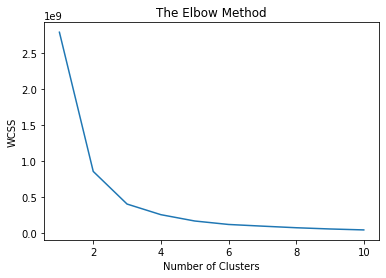

In [4]:
# Select all the columns except the column ' class'
X = df1.iloc[:,:-1].values

#using the elbow method to find the optimal number of clusters
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

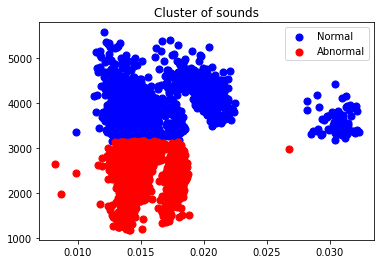

In [5]:
#Applying k-means to the mall dataset
kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=300, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

#Visualising the clusters
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], s=50,c='blue',label='Normal')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], s=50,c='red',label='Abnormal')
#plt.scatter(X[labels == 2, 0], X[labels == 2, 1], s=50,c='cyan',label='Transition')
plt.title('Cluster of sounds')

plt.legend()
plt.show()

In [6]:
from sklearn.metrics.cluster import rand_score
rand_score(labels, df1['class'])

0.571195880440243

In [7]:
df1['class'].value_counts()

0    3204
1     890
Name: class, dtype: int64

In [8]:
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1882],
       [   1, 2212]])

## DBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 130
Homogeneity: 0.410
Completeness: 0.393
V-measure: 0.402
Adjusted Rand Index: 0.561
Adjusted Mutual Information: 0.401
Silhouette Coefficient: 0.440


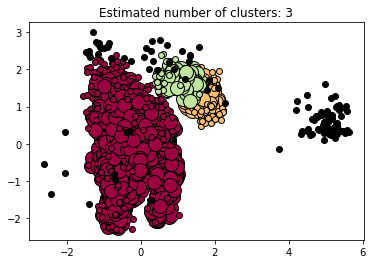

In [9]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=40).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_ = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
n_noise_ = list(labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['class'], labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df['class'], labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df['class'], labels_))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(df['class'], labels_))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(df['class'], labels_)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels_))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels_ == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()


In [10]:
(unique, counts) = np.unique(labels_, return_counts=True)

frequencies = np.asarray((unique, counts)).T
frequencies

array([[  -1,  130],
       [   0, 3531],
       [   1,  253],
       [   2,  180]])

In [11]:
label1 = pd.DataFrame(labels_,columns=['class'])
label1["class"].replace({-1:1,2:1}, inplace=True)

In [12]:
from sklearn.metrics.cluster import rand_score
rand_score(labels_, df1['class'])

0.8240344095528832

### Conclusion
With K-means clustering algorithtm the rand_score is 85.29% 

and DMSCAN algorithm the rand score is 82.40% for the pump machine model. 